In [2]:
# 1. import module

import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pycaret.regression import *

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = None


In [3]:
# 2. data import

raw_data = np.loadtxt("../data/inductance.csv",delimiter=",")
#raw_data = np.loadtxt("../data/coupling.csv",delimiter=",")
#raw_data = np.loadtxt("../data/loss.csv",delimiter=",")

column_names = ["width0","width1","height0","height1","move","coil0_width","coil1_width","gap0","gap1","freq","Ltx","Lrx1","Lrx2"]
#column_names = ["width0","width1","height0","height1","move","coil0_width","coil1_width","gap0","gap1","freq","k12","k13","k23"]
#column_names = ["width0","width1","height0","height1","move","coil0_width","coil1_width","gap0","gap1","0","freq","loss1","loss2","loss3"]

pd_data = pd.DataFrame(raw_data, columns=column_names)

pd_data.head()


,width0,width1,height0,height1,move,coil0_width,coil1_width,gap0,gap1,freq,Ltx,Lrx1,Lrx2
0,550.0,250.0,7000.0,3200.0,0.325,20.0,20.0,105.0,25.0,60.0,69.825757,26.117295,26.482791
1,850.0,300.0,6600.0,1000.0,0.150,20.0,20.0,110.0,40.0,60.0,92.506547,12.639088,12.745255
2,675.0,250.0,3300.0,1600.0,0.400,20.0,20.0,65.0,35.0,60.0,44.714385,12.234499,12.126098
3,550.0,275.0,4700.0,1800.0,0.300,20.0,20.0,120.0,50.0,60.0,44.479190,14.682593,14.673693
4,650.0,250.0,6600.0,2200.0,0.250,20.0,20.0,70.0,40.0,60.0,81.084770,18.488567,18.644697


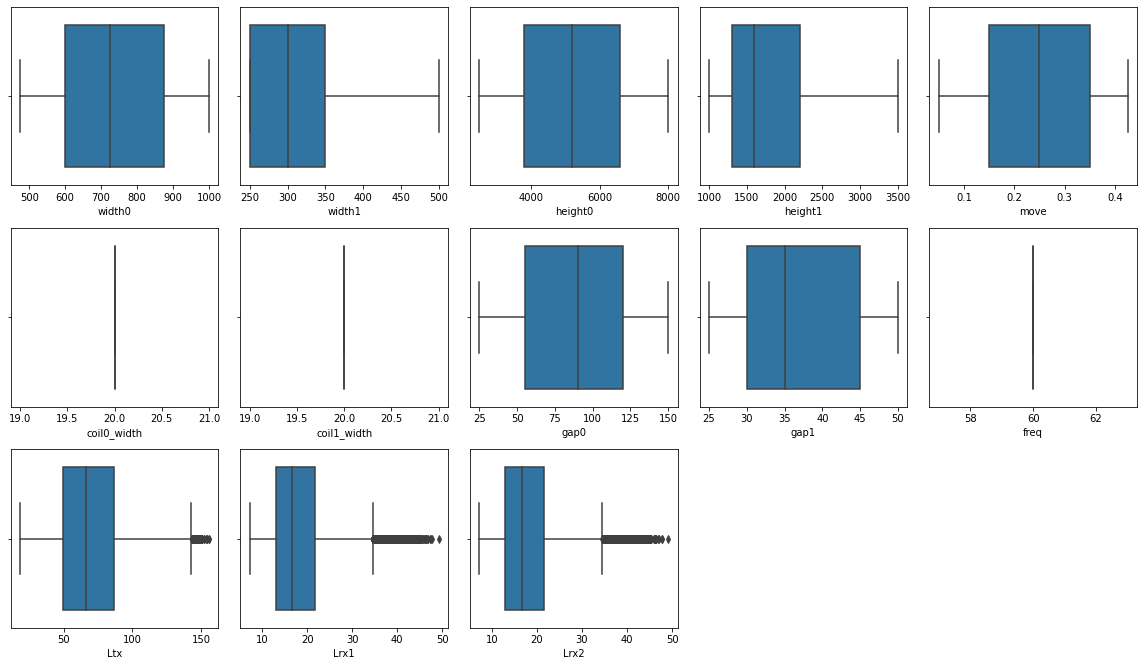

In [7]:
# 4. check outlier

plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(pd_data.columns)) :
    plt.subplot(4, 5, i+1)
    sns.boxplot(x=pd_data.loc[:, colName])
plt.tight_layout()
plt.show()

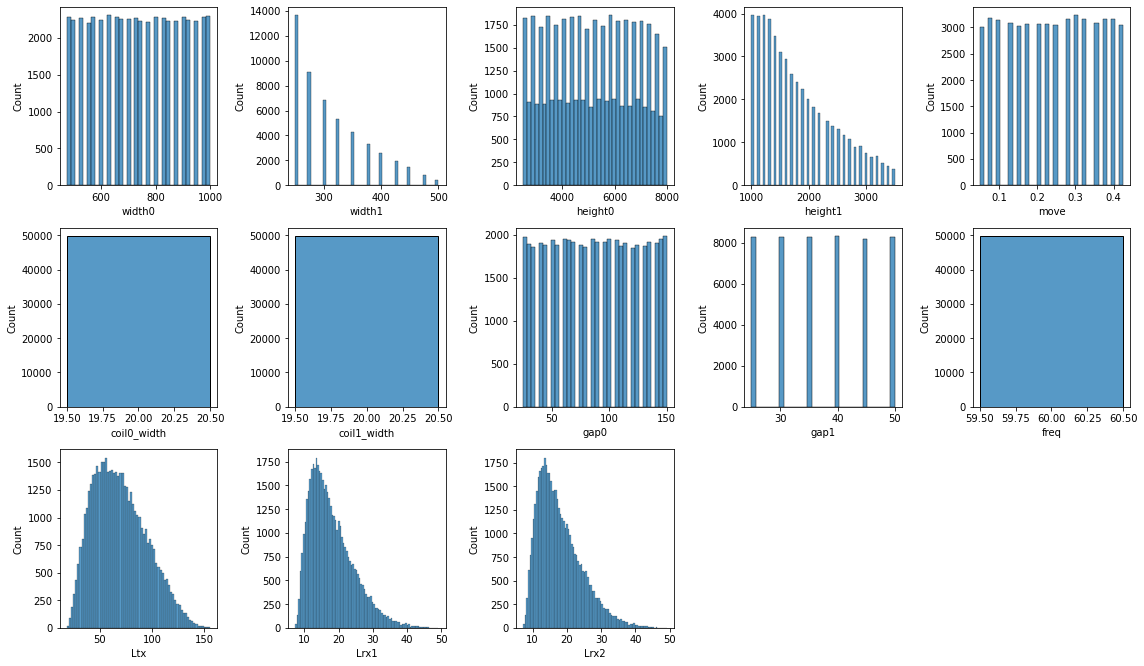

In [8]:
# 5. check data distribution

plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(pd_data.columns)) :
    plt.subplot(4, 5, i+1)
    sns.histplot(pd_data.loc[:, colName])
plt.tight_layout()
plt.show()

In [6]:
# 7. define outlier search function
def get_outlier(df=None, column=None, weight=1.5):
    
    # column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    data = df[column]
    quantile_25 = np.percentile(data.values, 25)  # 1/4 분위
    quantile_75 = np.percentile(data.values, 75)  # 3/4 분위
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight  # 이상치 최소 기준
    highest_val = quantile_75 + iqr_weight # 이상치 최대 기준
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = data[(data < lowest_val) | (data > highest_val)].index
    
    return outlier_index

col_input = list(pd_data.columns)[:-3]

# outlier 탐색 및 제거
outlier_index = {}
for i, colName in enumerate(col_input):
     outlier_index[i] = get_outlier(df=pd_data, column=f'{colName}', weight=1.5)
outlier_index

# 각각의 숫자들 리스트 안에 넣기
outlier_list = []
for i in range(len(outlier_index)):
    if list(outlier_index[i].values) == []:
        continue
    outlier_list.append(list(outlier_index[i].values))


# 리스트 안의 리스트들을 하나로 합치기
outlier_list = sum(outlier_list , [])
print('개수:', len(outlier_list))

# 중복 숫자 제거
outlier_list = set(outlier_list)
print('개수:', len(outlier_list))

# 다시 리스트 타입으로 변환
outlier_list = list(outlier_list)
print(type(outlier_list))

# 리스트 숫자 정렬
outlier_list.sort()

# outlier를 갖는 index에 해당하는 data drop
for i in outlier_list:
    pd_data.drop(i, axis=0, inplace=True)
pd_data.shape

개수: 1112
개수: 972
<class 'list'>


(49668, 13)

In [10]:
# split input/output

X = pd_data.drop(columns="Ltx").drop(columns="Lrx1").drop(columns="Lrx2")
Y = pd_data["Ltx"]

#X = pd_data.drop(columns="k12").drop(columns="k13").drop(columns="k23")
#Y = pd_data["k12"]

#X = pd_data.drop(columns="loss1").drop(columns="loss2").drop(columns="loss3")
#Y = pd_data["loss1"]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 765)

In [11]:
model = LGBMRegressor(random_state=765, n_estimators=2000, learning_rate=0.05, num_leaves=31)
model.fit(X_train,Y_train)

print(model)

LGBMRegressor(learning_rate=0.05, n_estimators=2000, random_state=765)


[0.9998015812035297, 0.27551135843075714, 0.1292178811309192, 0.3594688875701473, 0.41744947665787874, -0.009757910888408603]
[0.9998032237613503, 0.27494077334762873, 0.12631587424327692, 0.3554094459117215, 0.42393120549102115, -0.007819565465693084]
[0.9998015873642468, 0.27469697631853096, 0.12791462174466414, 0.35765153675702854, 0.41999289987526944, -0.013873599850478535]
[0.9998027339540397, 0.27712013691071824, 0.12936598627155943, 0.3596748340815068, 0.41882392903659804, -0.00298646838345715]
[0.9998018236998416, 0.272759433746626, 0.12576592550306379, 0.3546349186178143, 0.41699116607358006, -0.002216316927543856]


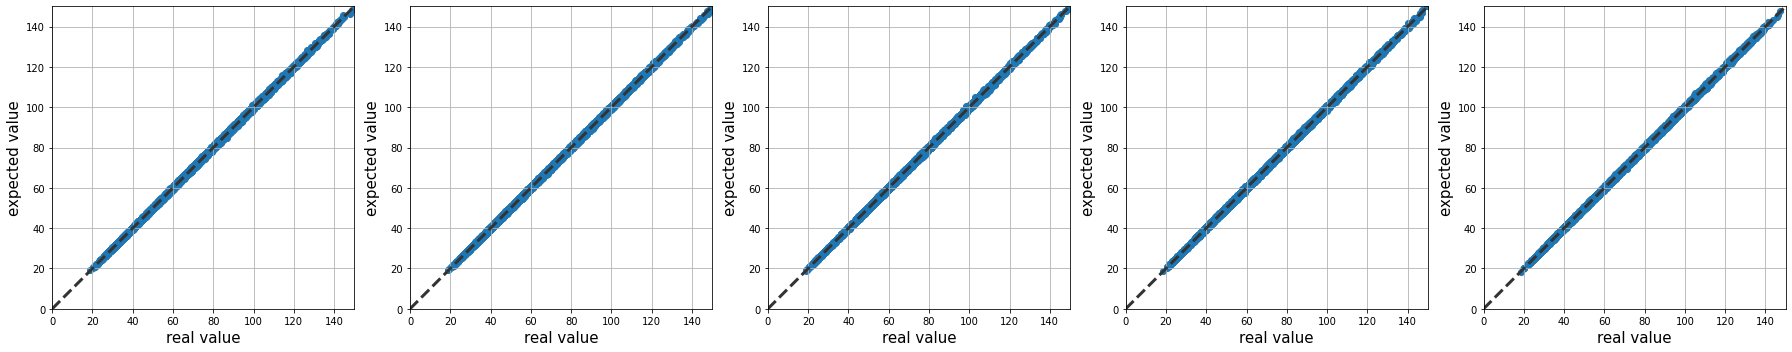

In [13]:
col_input = list(X.columns)

# 교차 검증용 데이터셋 구성
df_trains = []
df_valids = []

# MAPE 정의
def def_MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

# MPE 정의
def def_MPE(y_test, y_pred): 
	return np.mean((y_test - y_pred) / y_test) * 100

# KFold 검증
i = 0
plt.figure(figsize=(25, 5))
kfold = KFold(n_splits=5, random_state=765, shuffle=True)
for train_idx, test_idx in kfold.split(X[col_input]):

    # fold 후 train, test set 분할
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # regression model 생성
    model.fit(X_train, Y_train)

    # 예측
    fold_pred = model.predict(X_test)

    # 성능계산
    R2 = r2_score(Y_test, fold_pred)
    MAE = mean_absolute_error(Y_test, fold_pred)
    MSE = mean_squared_error(Y_test, fold_pred)
    RMSE = np.sqrt(MSE)
    MAPE = def_MAPE(Y_test, fold_pred)
    MPE = def_MPE(Y_test, fold_pred)

    print([R2, MAE,MSE,RMSE,MAPE,MPE])

    plt.subplot(1, 5, i+1)
    plt.scatter(Y_test, fold_pred)
    plt.xlabel("real value", fontsize=15)
    plt.ylabel("expected value", fontsize=15)
    plt.grid(True)
    plt.xlim(0, 150)
    plt.ylim(0, 150)
    plt.plot([0, 150], [0, 150], ls="--", c=".2", linewidth=3.0)
    i = i+1

plt.tight_layout()
plt.show()